# Introduction

I have decided to give Deep Learning a try. 

In the other markdown, I tried "regular" machine learning methodologies to solve the classification task. As I discussed there, simplicity is one of the aspects in which I would like to focus my solution on. Nevertheless, Deep Learning has become the state-of-the-art for many NLP tasks so I think that it is sensible to give it a try. A large increase in performance could motivate its application even with the increase in complexity. 

However, the dataset we have at our disposal includes "only" 65K documents. We all know that to apply Deep Learning you need tons of data and weeks of training, right? 

Well, this in not true, or at least, this is not anymore completely true thanks to **Transfer Learning**. If you are training a huge model from scratch, you do need a lot of data and GPU time. Lucklily for us, these huge models are already pre-trained for many languages using large datasets (e.g. Wikipedia). In more detail, these models are called **Language Models (LM)** because they are, surprisingly, ... models of your language. LM are trained on a rather simple (and silly at a first sight) task: given a sequence of words in a sentence, predict the next one. A properly trained LM should then identify that given the sentence `The dog is`, `black` is more likely than `red` (there is no red dogs). By optimizing this task, what the LM are actually doing is to learn the gramatical, lexical and semantical relationships of the language, thus grasping a deep understanding of its textual content. 

All we have to do is to adapt these LM to our particular domain. In layman words, the LM already speak English and we need to teach them to talk *HuffingtonPostish*. 65K documents are not enough to learn English, but they are definitely enough to learn the nuances of the dataset.

Cool, now we know *HuffingtonPostish*, but the business case was to create a classifier. Why am I even doing all of this? In the traditional ML methodologies that I implemented in the other markdown, we were feeding our algorithms with a rather simple representation of our textual contents (The TF-IDF vectors). Now, thanks to the LM, I can feed my classifier with a much more detailed and accurate representation of the input textual content. Therefore, it should be easier to the classifier to better categorize the textual content.


Summing up, my strategy will be:

1.   Use a pre-trained English Language Model trained over a large dataset as starting point.
2.   Adapt this language model to our domain. To that end, I will retrain the model to learn the particular aspects of the dataset.
3. Create a Machine Learning Classifier on top of the dataset language model


**Side note: I have trained this model on Google Colab to be able to use a GPU.For this reason, I did not include anything about the configuration of the GPU or the installation of the required libraries. To execute it I do recommend you to update it to Google Colab**


## Fast AI


To facilitate the training of this deep learning approach, I will make use of the [fast.ai library](https://www.fast.ai/). In particular, the [`text`](https://docs.fast.ai/text.html) module of the fast.ai library contains all the necessary functions. Specifically:

- [`text.transform`](https://docs.fast.ai/text.transform.html#text.transform) contains all the scripts to preprocess the data, from raw text to token ids,
- [`text.data`](https://docs.fast.ai/text.data.html#text.data) contains the definition of [`TextDataBunch`](https://docs.fast.ai/text.data.html#TextDataBunch), which is the main class we need in NLP,
- [`text.learner`](https://docs.fast.ai/text.learner.html#text.learner) contains helper functions to quickly create a language model or an text classifier.



In [ ]:
# I needed this to load data from my GDrive
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive



## Training an classifier model


To create my model I am going to apply the following steps:

1. Fine-tuning an [AWD-LSTM](https://arxiv.org/abs/1708.02182) model to create a language model based on our data.
1. Building a classifier based on the learned language model

### Reading and viewing the data

First let's import everything we need for text.

In [3]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.text.all import *
import pandas as pd

ModuleNotFoundError: No module named 'fastai'

I will now read the dataset from the original JSON files

In [ ]:
training_df = pd.read_csv('./nlp_disaster/data/train.csv', sep=',', index_col=0)
training_df = training_df.sample(frac=1).reset_index(drop=True)
training_df.head(20)

,keyword,location,text,target
0,burning,"Spokane, Washington 99206",Parents are taking their kids to Burning Man and one 11 year old thinks it's 'better than... http://t.co/wp6V1BHhoQ,0
1,detonate,NaN,A young heavyweight rapping off of detonate I been a leader not a lemon better get it straight ??,0
2,tragedy,houston,@itss_selenaluna like a beautiful ass tragedy lol,1
3,mudslide,Notts,#BakeOffFriends #GBBO 'The one with the mudslide and the guy with the hat',0
4,thunder,NaN,Ebay Snipe RT? http://t.co/SlQnph34Nt Lego Power Miners Set 8960 Thunder Driller Boxed. ?Please Favorite &amp; Share,0
5,tornado,God is Love.,My room looks like a tornado passed through it and my OCD is not having it.,0
6,debris,"Belbroughton, England",#aerospace #exec Plane debris is from missing MH370 - Part of the aircraft wing found on Reunion Island is from th... http://t.co/S2wm8lh7oO,1
7,derailment,NaN,http://t.co/BAGEF9lFGT 25 killed 50 injured in Madhya Pradesh twin train derailment http://t.co/bVxqA3Kfrx,1
8,trouble,?,When there's trouble you know who to caaaaaall,0
9,hailstorm,far away,Calgary news weather and traffic for August 5 * ~ 90 http://t.co/qBdRYXSGlC http://t.co/VZOd7qFFlv,0


In [ ]:
test_df = pd.read_csv('./nlp_disaster/data/test.csv', sep=',', index_col=0)
test_df.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### Getting your data ready for modeling

fast.ai provides some helpful loaders to format the input data to the format required by the Deep Learning Model.

The main structure we need to create is the [`DataBunch`](https://docs.fast.ai/basic_data.html#DataBunch) that creates the training and validation sets by grabbing the textual data from the required columns.

Here we'll use the method <code>from_df</code> of the [`TextLMDataBunch`](https://docs.fast.ai/text.data.html#TextLMDataBunch) (to get the data ready for the fine-tuning of the language model) and [`TextClasDataBunch`](https://docs.fast.ai/text.data.html#TextClasDataBunch) (to get the data ready for the classification step) classes.

In [ ]:
# Language model data
df_all = pd.concat([training_df, test_df])
splits = [list(range_of(training_df)), list(range(len(training_df), len(df_all)))]
tfms = [attrgetter("text"), Tokenizer.from_df(2), Numericalize()]
dsets = Datasets(df_all, [tfms], splits=splits, dl_type=LMDataLoader)

bs,sl = 104,25
dls = dsets.dataloaders(bs=bs, seq_len=sl)

In [ ]:
dls.show_batch()


,text,text_
0,xxbos xxup u.s . xxmaj forest xxmaj service firefighter xxmaj david xxmaj xxunk xxunk died in the ' frog xxmaj fire ' in the xxmaj,xxup u.s . xxmaj forest xxmaj service firefighter xxmaj david xxmaj xxunk xxunk died in the ' frog xxmaj fire ' in the xxmaj xxunk
1,bloody xxunk now xxbos xxmaj path of xxmaj obliteration \n xxmaj back xxmaj from xxmaj the xxmaj dead \n xxmaj story by xxunk xxunk \n\n▁,xxunk now xxbos xxmaj path of xxmaj obliteration \n xxmaj back xxmaj from xxmaj the xxmaj dead \n xxmaj story by xxunk xxunk \n\n▁ http
2,usgs xxup eq : m 1.9 - 15 km e of xxmaj anchorage xxmaj alaska : xxmaj time2015 - 08 - 06 00:11:16 xxup utc2015,xxup eq : m 1.9 - 15 km e of xxmaj anchorage xxmaj alaska : xxmaj time2015 - 08 - 06 00:11:16 xxup utc2015 -
3,suspect killed in xxunk … http : / / t.co / xxunk xxbos xxmaj xxunk xxmaj rousey would be ' close ' to making xxmaj,killed in xxunk … http : / / t.co / xxunk xxbos xxmaj xxunk xxmaj rousey would be ' close ' to making xxmaj floyd
4,latest drought conditions in your area https : / / t.co / xxunk xxbos xxmaj now xxmaj playing : xxmaj landslide by xxmaj xxunk xxmaj,drought conditions in your area https : / / t.co / xxunk xxbos xxmaj now xxmaj playing : xxmaj landslide by xxmaj xxunk xxmaj xxunk
5,/ t.co / xxunk xxmaj minecraft : xxup night xxup lucky xxup block xxup mod ( bob xxup apocalypse xxup wither 2.0 & & xxup,t.co / xxunk xxmaj minecraft : xxup night xxup lucky xxup block xxup mod ( bob xxup apocalypse xxup wither 2.0 & & xxup more
6,xxmaj wounded xxmaj families | xxup xxunk - xxmaj the xxmaj world xxmaj seen xxmaj from xxmaj rome http : / / t.co / xxunk,wounded xxmaj families | xxup xxunk - xxmaj the xxmaj world xxmaj seen xxmaj from xxmaj rome http : / / t.co / xxunk xxbos
7,/ / t.co / xxunk xxbos xxunk xxmaj yes xxmaj i 'm a bleeding heart xxunk . xxbos xxmaj road xxmaj hazard @ xxup xxunk,/ t.co / xxunk xxbos xxunk xxmaj yes xxmaj i 'm a bleeding heart xxunk . xxbos xxmaj road xxmaj hazard @ xxup xxunk xxup
8,t.co / xxunk - / xxbos xxmaj pic of 16yr old xxup pkk suicide bomber who detonated bomb in xxmaj turkey xxmaj army trench released,/ xxunk - / xxbos xxmaj pic of 16yr old xxup pkk suicide bomber who detonated bomb in xxmaj turkey xxmaj army trench released http



Since this step can be a bit time-consuming, it's best to save the result with:

You can then reload those results with:

### Fine-tuning

We can now use the `data_lm` object I created earlier to fine-tune a pretrained language model. [fast.ai](http://www.fast.ai/) has an English model with an [AWD-LSTM architecture](https://arxiv.org/abs/1708.02182) available. To use it, we can create a learner object that will directly create the model, download the pretrained weights and be ready for fine-tuning.

Neural nets in general, and the AWD_LSTM model in particular, are well know for having a huge number of hyperparameters to optimize. 

I am deliberately using the default values that fast.ai implements. fast.ai is well know for their superconvergent models that are able to train in just a few steps. This is done through their thoughtful research about initializations, regularization, optimizers and batch normalization. All of these findings are implmented in their default values, so, for most of the tasks, we can safely use them.

There is though an hyperparameter that requires careful optimization, the learning rate. Learning rate refers to the "speed" at which the optimizer is updating the neural net parameters in the backpropagation step. Pick a large learning rate and your NN will never converge. Pick a small rate and you will wait forever to see your NN achive a good performance or to see your NN stuck at a local minima. 

I will make use of the `lr_find` method in fast.ai to make sense of the values that are optimal for my data



In [ ]:
config = awd_lstm_lm_config.copy()
config.update({'input_p': 0.6, 'output_p': 0.4, 'weight_p': 0.5, 'embed_p': 0.1, 'hidden_p': 0.2})
model = get_language_model(AWD_LSTM, len(dls.vocab), config=config)

opt_func = partial(Adam, wd=0.1, eps=1e-7)
cbs = [MixedPrecision(clip=0.1), ModelReseter, RNNRegularizer(alpha=2, beta=1)]


In [ ]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), opt_func=opt_func, cbs=cbs, metrics=[accuracy, Perplexity()])

SuggestedLRs(lr_min=0.0022692142054438593, lr_steep=4.2668071387197415e-07)

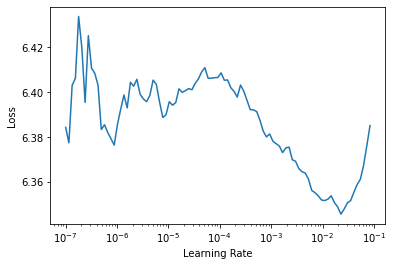

In [ ]:
learn.lr_find(start_lr=1e-7, end_lr=0.2)

What we see in this figure is the projection of how the model will perform based on different learning rates.

We can see that around 5e-01 the training starts to go south (i.e., the loss/error starts rocketing). The minimal loss is around 1e-1. Nevertheless, we have to choose a value that is approximately in the middle of the sharpest downward slope. Why?! Well, for a more intuitive explanation you can check this [blog post](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html). Basically, the reason is:

> [...] the minimum value is already a bit too high, since we are at the edge between improving and getting all over the place. We want to go one order of magnitude before, a value that's still aggressive (so that we train quickly) but still on the safe side from an explosion.


This is given as an indication by the LR Finder tool, so let's try 1e-2.



In [ ]:
learn.fit_one_cycle(20, 0.0022, moms=(0.8,0.7,0.8), div=10)


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,6.135139,5.494511,0.119225,243.352524,00:34
1,6.126870,5.493145,0.119225,243.020187,00:34
2,6.128255,5.488292,0.119225,241.843719,00:33
3,6.126372,5.487077,0.119225,241.550171,00:33
4,6.118368,5.485628,0.119225,241.200394,00:33
5,6.117770,5.482721,0.119225,240.500183,00:33
6,6.109224,5.477413,0.119225,239.227066,00:34
7,6.096096,5.477844,0.119225,239.330093,00:34
8,6.092522,5.472507,0.119225,238.056137,00:33
9,6.084905,5.473016,0.119225,238.177521,00:34


After just only one epoch we have a pretty good result (i.e., remember that we are still fine-tuning the language model, so guessing right about one third of times which is going to be the next word is a pretty good model). It seems that the default values of the library based on the super-convergence approach are just fine. So, I am not going to pay attention to them anymore. In a more developed solution, we could spend some time trying to optimize them.

At this point it is important to explain what are we actually training. As I explained before, we have a pre-trained model of the English language. By pretrained, we mean nothing more the Neural Net has a set of weights already learned.
This model is quite deep, it has many number of layers with millions of parameters (a.k.a. weights) to learn. It has been posible to train such a huge model, because the entire Wikipedia was used. 

However, we only have a small bunch of news reports to adapt/fine-tune the model to our domain. Fine-tuning is nothing more than modifying a little bit the weights of the model, so they reflect the particular relationships in our data. But, since our dataset is rather small, if we try to retrain all the layers in the model, we will completely destroy it (the model will catastrophically forget everything learned from Wikipedia). 

If you think about it, it makes sense, the deeper layers in the model are actually learning the basic aspects of the language, while shallow layers are in charge of more high-level relationships. We do not want to change the deeper layers. Basic language relationships are the same in our dataset than in the entire English language (e.g., verb tenses, subject-object relationships). What we actually want to modify is the last layers of the model in charge of learning the high level relationships (e.g. Obama does something). Well, that's exactly what the default training method in fast.ai is doing: It freezes the deeper layers so you do not modify them while you are fine-tuning your model. How convenient, right? 

In the previous step, we have fine-tuned the LM to the particular content of our dataset. To do this, we just trained the last layers in our model to avoid forgetting everything. Now that our model is in a *stable* state (it has learned from our data without losing what learned from Wikipedia), we can further train our model by unfreeze all the layers.

The rationale is the following: we can slightly change the weights of all the layers so even the most basic aspects of the language can be redefined according to our data (e.g. Napoleonic wars Wikipedia pages can learn the model that France<-->invade is a likely outcome; however, I do not expect to read anything about a French invasion in the HuffPost). 

It has been experimentally proven that this process can improve the performane of Deep Learning models (see this [Howard and Ruder's paper](https://arxiv.org/pdf/1801.06146.pdf) for more details). We have to be extremely careful with this process, otherwise we will ruin all our work. To that end, I have reduced my learning rate by an order of magnitude



In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 0.00022)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,6.005759,5.457955,0.119225,234.617111,00:33
1,6.013834,5.459658,0.119225,235.017075,00:33
2,6.013258,5.460328,0.119225,235.174469,00:33
3,6.004877,5.460502,0.119225,235.215393,00:33
4,6.007364,5.460192,0.119270,235.142502,00:33
5,6.012168,5.459572,0.119248,234.996902,00:33
6,6.005960,5.459644,0.119248,235.013702,00:33
7,6.006225,5.459207,0.119282,234.911072,00:33
8,6.004986,5.459043,0.119316,234.872543,00:33
9,6.002782,5.458996,0.119316,234.861572,00:33


Cool! Only one epoch and my model has been improved.


To understand what our language model is learning, you can run the [`Learner.predict`](https://docs.fast.ai/basic_train.html#Learner.predict) method and specify the number of words you want it to guess.

In [ ]:
for _ in range(5):
  print(learn.predict("Haha South Tampa"))

/usr/local/lib/python3.6/dist-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


IndexError: ignored

It doesn't make much sense (we have a tiny vocabulary here and didn't train much on it) but note that it respects basic grammar (which comes from the pretrained model) while it has adapted the conversation to the content of the dataset.



I could futher train or experiment with more hyperparameters, but since the language model is not the final outcome and the LM seems good enough, I will move on to the classification step.


We can save the model for later uses. We need to save the encoder (the part that given a textual content creates the representation) which is the only part of the model needed for classification in the next section (i.e., the other part is the decoder in charge of translating the textual representation back to the text again).

In [ ]:
learn.save_encoder('/content/drive/My Drive/nlp_disaster/models/ft_enc_extended')

### Building a classifier

It's now time to actually create the classifier taking our fine-tuned encoder. For this step we need the `data_clas` object we created earlier.

For this step, I will use again the default values in fast.ai to create a classification model. In this case, I will use the `text_classifier_learner`. We need to also tell the classifier that we want to use the fine-tuned encoder that we have just learned.

In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()
learn.load_encoder('/content/drive/My Drive/nlp_disaster/models/ft_enc_extended')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6613 items)
x: TextList
xxbos xxunk xxmaj so going to make any bomb threats ? xxunk,xxbos xxmaj path of xxmaj obliteration 
  xxmaj back xxmaj from xxmaj the xxmaj dead 
  xxmaj story by xxunk xxunk 
 
  http : / / t.co / xxunk,xxbos xxmaj element of xxmaj freedom : xxmaj the xxmaj biggest xxmaj party of the xxmaj summer @ xxmaj mirage xxmaj saturday ! xxmaj tickets at http : / / t.co / 7hanpcr5rk,xxbos xxmaj is it possible to sneak into a hospital so i can stab myself with a hazardous needle and xxunk some crazy disease into my xxunk until i die,xxbos # pbban ( xxmaj temporary:300 ) xxunk @'armageddon | xxup do xxup not xxup kill | xxup flags xxup only | xxmaj fast xxup xp ' for xxmaj reason
y: CategoryList
0,1,0,0,0
Path: .;

Valid: LabelList (1000 items)
x: TextList
xxbos xxmaj flooding kills 166 displace over one million in xxmaj pakistan http : / / t.co / xxunk 
 
  xxmaj at least 166 people have been killed and nearly 11 xxunk

epoch,train_loss,valid_loss,accuracy,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


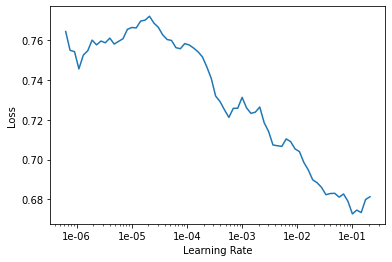

In [ ]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

Thanks to fast.ai super-convergence strategies, I think that just one epoch should be enough. Let's see

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.570721,0.544005,0.731000,00:03


In [ ]:
learn.save('./nlp_disaster/models/1')


Great! As I expected. 87% of accuracy.

This is in the line of the accuracy reported by the simpler models that I already implemented in the other markdown. However, we need to compare them in terms of the F1 macro AVG as we discussed. In additon we can futher train this model. As in the language modeling training, we have just trained the last layers of the model, we can gradually unfreeze the rest of the model and train it together.

In this case I will not unfreeze all the model at a time, but in different steps. This gradual unfreezing has been experimentally proven to improve the training process (again, check Howard and Ruder's paper).

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.545875,0.525755,0.726000,00:04


In [ ]:
learn.save('./nlp_disaster/models/2nd')


In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-2/2/(2.6**4),1e-2/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.505258,0.506216,0.752000,00:06


In [ ]:
learn.save('./nlp_disaster/models/models/3rd')


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-2/10/(2.6**4),1e-2/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.485252,0.522730,0.741000,00:09
1,0.485891,0.506821,0.761000,00:08
2,0.474911,0.505298,0.766000,00:08
3,0.477685,0.506820,0.766000,00:08
4,0.453993,0.524493,0.757000,00:08
5,0.439716,0.514499,0.762000,00:09
6,0.453190,0.504143,0.766000,00:08
7,0.441064,0.518208,0.763000,00:08
8,0.420555,0.526317,0.766000,00:09
9,0.405216,0.518275,0.762000,00:09


In [ ]:
learn.save('./nlp_disaster/models/classifier_5')


As can be seen in the results, our model is now offering accuracies up to 95%! Better than those we had with LR, RF or SVM.

Again, we can predict on a raw text (the category in this case) by using the [`Learner.predict`](https://docs.fast.ai/basic_train.html#Learner.predict) method.

In [ ]:
learn.predict("This Artist Gives Renaissance-Style Sculptures...")

(Category D,
 tensor(3),
 tensor([2.6761e-01, 1.5789e-03, 1.7408e-03, 6.0898e-01, 1.7072e-03, 2.9603e-02,
         4.3496e-05, 8.4169e-05, 8.8507e-02, 1.4714e-04]))

In order to have a full report of this model performance, I will ask the model to offer me all the predictions and inspect the confusion matrix and the classification report

In [ ]:
# get predictions
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,1523,9,2,15,1,8,1,28,14,2
1,29,1727,28,12,2,16,19,90,25,7
2,2,29,1100,19,2,2,24,35,53,4
3,194,24,150,1826,22,26,44,135,28,17
4,0,4,0,12,1987,36,2,0,3,30
5,42,32,3,23,29,5947,7,11,11,47
6,2,10,14,12,1,4,12624,6,2,3
7,17,35,18,19,1,2,2,2392,6,1
8,51,60,81,15,3,3,5,40,521,0


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(targets, predictions))

              precision    recall  f1-score   support

           0       0.95      0.81      0.88      1878
           1       0.88      0.89      0.89      1945
           2       0.87      0.78      0.82      1405
           3       0.74      0.93      0.82      1971
           4       0.96      0.96      0.96      2077
           5       0.97      0.98      0.97      6098
           6       1.00      0.99      0.99     12739
           7       0.96      0.87      0.91      2756
           8       0.67      0.78      0.72       670
           9       0.93      0.96      0.95      2632

    accuracy                           0.94     34171
   macro avg       0.89      0.89      0.89     34171
weighted avg       0.95      0.94      0.94     34171



As can be seen in both the confusion matrix and in the classification report, the model is better not only in terms of accuracy, but also in its performance for all the classes when compared to the non Deep Learning models. Something that I care about since the start.

As expected, there are some classes for which the model performs better (they are easier to predict or we have more data for them). However, we get a reasonable performance for most of the classes (I am a little bit worried by class 8, but since we do not have many data I guess I can accept this result) 

Finally, saving the model object to reuse it.

In [ ]:
learn.save('.nlp_disaster/models/final_class_model')